In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:
# library road 

import os, random, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionResNetV2
from PIL import Image 

print('a')

a


Found 1000004 images belonging to 2 classes.
Found 428572 images belonging to 2 classes.
x_data shape :  (20, 299, 299, 3)
t_data shape :  (20,)
[0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.]


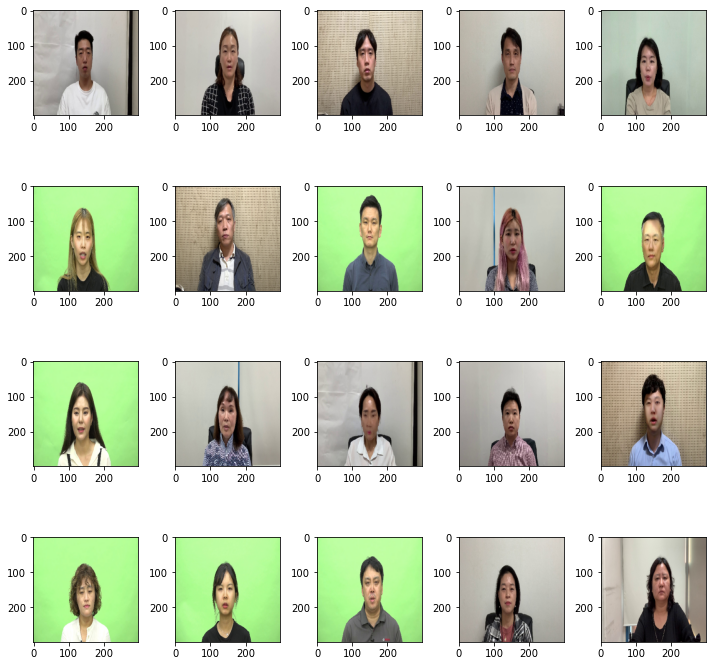

In [3]:

train_dir = './data/project_deepfake/deepfake_1st'
#validation_dir = './data/deepfake_ex/dataset/validation'


train_list = glob(os.path.join(train_dir, '*', '*.JPG'))

len(train_list)

dir_list = sorted(glob(os.path.join(train_dir, '*')))

# ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.3)
#validation_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_directory(
    train_dir, 
    classes=['real','fake'], 
    target_size=(299,299), 
    batch_size=20, 
    class_mode='binary',
    subset='training') # 다항이면 categorical
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    classes=['real','fake'], 
    target_size=(299,299), 
    batch_size=20, 
    class_mode='binary',
    subset='validation') # 다항이면 categorical

# generator에서 출력된 데이터의 shape확인
for x_data, t_data in train_generator:
    print('x_data shape : ', x_data.shape) # (20,299,299,3)
    print('t_data shape : ', t_data.shape) # (20,)
    break;

fig = plt.figure(figsize=(10,10))
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))
    
for x_data, t_data in train_generator:
    for idx, img_data in enumerate(x_data): # idx => 0~19 , img_data =>(150,150,3)
        axs[idx].imshow(img_data)
    print(t_data)
    break;
    
fig.tight_layout()
plt.show()


x_data shape : (20, 299, 299, 3)
t_data shape : (20,)
[1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1.]


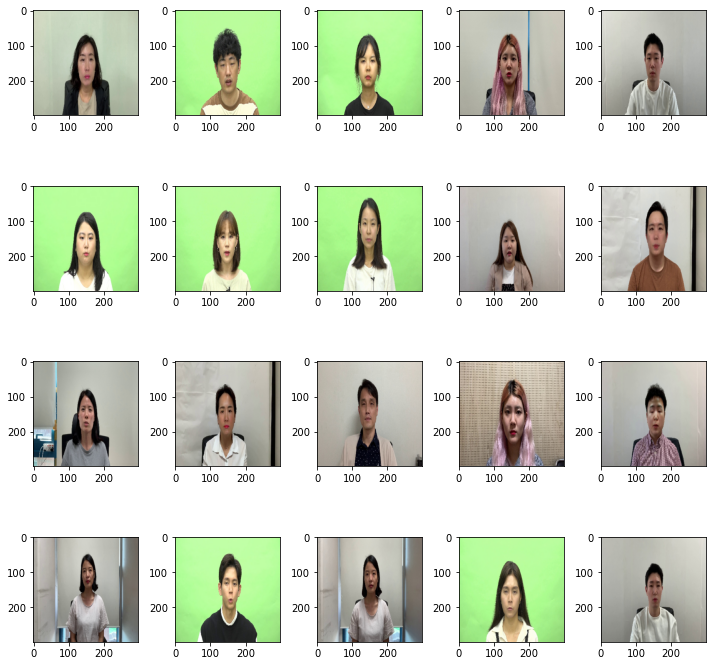

In [4]:
# generator로부터 출력된 데이터의 shape를 확인
for x_data, t_data in train_generator:
    print('x_data shape : {}'.format(x_data.shape)) # (20, 299, 299, 3)
    print('t_data shape : {}'.format(t_data.shape)) # (20,)
    break; # generator는 batch_size만큼 계속 무한 반복 그래서 break으로 for문에서 나와야 함

fig = plt.figure(figsize=(10,10)) # 10 inch 단위가 inch
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))
    
for x_data, t_data in train_generator:
    # x_data의 shape : (20, 299, 299, 3)
    for idx, img_data in enumerate(x_data): # idx => 0~19, img_data => (150, 150, 3)
                                             # enumerate() => 앞의 차원을 기준으로 차원의 정보를 불러오는 함수
        axs[idx].imshow(img_data)
    print(t_data)
    break;
    
fig.tight_layout()
plt.show()

In [5]:
# Callback List
# EarlyStopping: 성능 향상 멈추면 훈련 중지
# ModelCheckpoint: 에포크마다 가중치 저장
# ReduceLROnPlateau: 검증 손실 향상되지 않으면 학습률 감소시킴

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 검증 정확도 모니터링
                                                   patience=5),             # 1 epoch보다 더 길게 정확도 향상되지 않으면 훈련 중지
                  
                  tf.keras.callbacks.ModelCheckpoint(filepath='./lprojectmodel_1107.h5',
                                                     monitor='val_loss',    # 검증 loss 모니터링
                                                     save_best_only=True),  # 가장 좋은 모델을 저장
                  
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  # 검증 loss 모니터링
                                                      factor=0.1,           # 콜백 호출시 학습률 10배로 줄임
                                                      patience=5)]          # 검증손실이 해당 epoch만큼 좋아지지 않으면 콜백 호출

In [6]:
with tf.device('/device:GPU:1'):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(299, 299, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.5))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())      
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    print(model.summary())
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 35, 35, 128)       0

In [7]:
with tf.device('/device:GPU:1'):
    # 학습실행
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=500,  #  batch_size * steps_per_epoch이 train데이타의 양보다 크면 안됨!!!!!
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=50)
    
model.save('./Iprojectmodel_1107.h5')

Epoch 1/30
500/500 [==============================] - 117s 235ms/step - loss: 0.6541 - accuracy: 0.5827 - val_loss: 0.7131 - val_accuracy: 0.4320
Epoch 2/30
500/500 [==============================] - 116s 233ms/step - loss: 0.5629 - accuracy: 0.6847 - val_loss: 1.0335 - val_accuracy: 0.4600
Epoch 3/30
500/500 [==============================] - 119s 238ms/step - loss: 0.4007 - accuracy: 0.8125 - val_loss: 0.8965 - val_accuracy: 0.5800
Epoch 4/30
500/500 [==============================] - 120s 241ms/step - loss: 0.2819 - accuracy: 0.8782 - val_loss: 1.3246 - val_accuracy: 0.5720
Epoch 5/30
500/500 [==============================] - 119s 239ms/step - loss: 0.2431 - accuracy: 0.8997 - val_loss: 1.2880 - val_accuracy: 0.5780
Epoch 6/30
500/500 [==============================] - 118s 235ms/step - loss: 0.2193 - accuracy: 0.9079 - val_loss: 1.8310 - val_accuracy: 0.5670
Epoch 7/30
500/500 [==============================] - 116s 233ms/step - loss: 0.1805 - accuracy: 0.9261 - val_loss: 1.7195 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


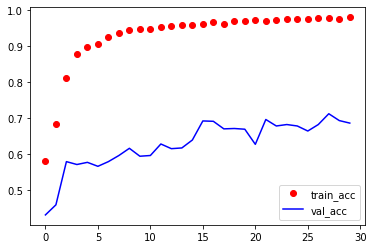

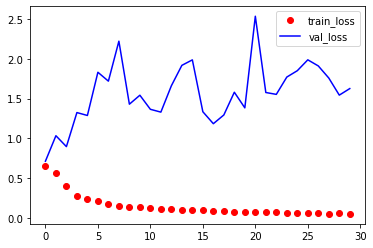

In [9]:
% matplotlib inline
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(history.history.keys())
plt.plot(history.history['accuracy'], 'bo', color='r', label='train_acc')
plt.plot(history.history['val_accuracy'], 'b', color='b', label='val_acc')
plt.legend()
plt.show()
plt.plot(history.history['loss'], 'bo', color='r', label='train_loss')
plt.plot(history.history['val_loss'], 'b', color='b', label='val_loss')
plt.legend()
plt.show()

In [ ]:
# 테스트

path_test = './data/landmark/public/test/'
df = pd.read_csv('./data/landmark/public/sample_submisstion.csv') 

id_list = df.iloc[:,0].values 

id_list=[path_test + '/' + num[0] + '/' + num + '.JPG' for num in id_list]

image_w = 299 
image_h = 299 
 
test_img_arr = [] 
prediction=np.zeros(shape=(len(id_list),nr_of_classes))
batch_size=20                     
steps=(len(id_list)//batch_size)+1
print('-'*70)                     
for e in range(steps):
    for i, f in enumerate(id_list[e*batch_size:(e+1)*batch_size]): 
        img = Image.open(f) 
        img = img.convert("RGB") 
        img = img.resize((image_w, image_h)) 
        data = np.asarray(img)
        data = data/255                # rescale
        test_img_arr.append(data)  

    test_img_arr = np.array(test_img_arr)
                     
    result = model.predict(test_img_arr)
    prediction[e*batch_size:(e+1)*batch_size] = result
    test_img_arr = []
    print(f'Step {e+1}/ {steps}', end='\n')
print('-'*70)

In [ ]:
# 제출파일 생성

df = pd.DataFrame({'id': df.iloc[:,0].values, 
                   'landmark_id': np.argmax(prediction, axis=1),
                   'conf':np.amax(prediction, axis=1) }, 
                    columns = ['id','landmark_id','conf']) 

display(df) 

df.to_csv (r'./data/landmark/public/sample_submisstion_comment.csv', index = False, header=True) 